In [0]:
# https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/

!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
downloaded = drive.CreateFile({'id':"1nbOaQv3boOG5bsFybrInI8cZLsAHLf2m"})   # replace the id with id of file you want to access
downloaded.GetContentFile('USvideos.csv')        # replace the file name with your file


In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data = pd.read_csv('USvideos.csv')

In [0]:
data.head()

,title,cleaned_tags,views,likes,description
0,WE WANT TO TALK ABOUT OUR MARRIAGE,shantell martin,748374,57527,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,The Trump Presidency: Last Week Tonight with J...,last week tonight trump presidency last week t...,2418783,97185,"One year after the presidential election, John..."
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",racist superman rudy mancuso king bach racist ...,3191434,146033,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,Nickelback Lyrics: Real or Fake?,rhett and link gmm good mythical morning rhett...,343168,10172,Today we find out if Link is a Nickelback amat...
4,I Dare You: GOING BALD!?,ryan higa higatv nigahiga i dare you idy rhpc ...,2095731,132235,I know it's been a while since we did this sho...


In [0]:
def clean_row(row):
  row = row.casefold()
  row = row.replace('|'," ")
  return row.replace('\"',"")

data['cleaned_tags'] = data['tags'].apply(lambda row: clean_row(row))
data = data[['title', 'cleaned_tags','views', 'likes', 'description']]

data = data[data['cleaned_tags'] != '[none]']  

In [0]:
# extract a vector form of the text

tfidf_cleaned_tags = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 1000,
    stop_words = 'english'
)
tfidf_cleaned_tags.fit(data.cleaned_tags)
text_cleaned_tags = tfidf_cleaned_tags.transform(data.cleaned_tags)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


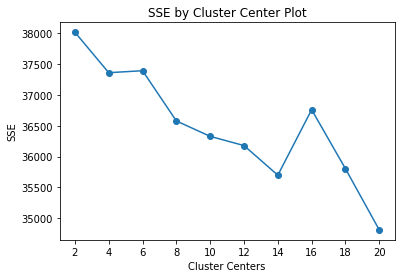

In [0]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text_cleaned_tags, 20)


In [0]:
clusters = KMeans(n_clusters=20)
cluster_array = clusters.fit_predict(text_cleaned_tags)

In [0]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=1000).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text_cleaned_tags, cluster_array)

In [0]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text_cleaned_tags, cluster_array, tfidf_cleaned_tags.get_feature_names(), 10)


Cluster 0
christmas,love,react,live,video,new,animation,vlog,diy,funny

Cluster 1
gossip,video,breaking,kardashian,politics,celebrity,latest,cnn,cbs,news

Cluster 2
year,oscars,winter,funny,new,2017,sports,olympics,best,2018

Cluster 3
fox,ti,raw,solo,wwe,00,jedi,sp,wars,star

Cluster 4
seth,fallon,rhett,link,nbc,night,sketch,snl,funny,comedy

Cluster 5
kylie,james,review,charles,drugstore,face,cosmetics,beauty,tutorial,makeup

Cluster 6
cinema,disney,movies,teaser,review,trailers,official,film,trailer,movie

Cluster 7
awards,live,country,dance,pop,song,new,official,video,music

Cluster 8
brown,people,love,grace,feat,pop,alternative,dance,records,columbia

Cluster 9
motion,comic,mo,commercial,marvel,slow,panther,bowl,super,black

Cluster 10
kitchen,challenge,cook,make,chef,chocolate,cake,cooking,recipe,food

Cluster 11
jokes,cbs,celeb,famous,joke,night,corden,funny,colbert,late

Cluster 12
degeneres,online,trailer,season,television,movies,tv,netflix,series,ellen

Cluster 13
kelly,clar

In [0]:
for i in range(0,cluster_array.size):
  print(str(i) + ' ' + str(cluster_array[i]))

In [0]:
# examples of recommendations
import random

def recommend_video(row_of_video):
  cluster_number = cluster_array[row_of_video]
  rand_number = random.randint(0,cluster_array.size-1)
  while cluster_array[rand_number] != cluster_number:
    rand_number = random.randint(0,cluster_array.size-1)
  return data.iloc[rand_number]

print( "Given: " + str(data.iloc[39393]))
print()
print( 'Prediction: ' + str(recommend_video(39393)))

Given: title                   That Time It Rained for Two Million Years
cleaned_tags    dinosaurs dinos paleo paleontology scishow eon...
views                                                     1925345
likes                                                       46673
description     Check out our NEW POSTER: https://store.dftba....
Name: 40927, dtype: object

Prediction: title                                      How Zero-G Planes Work
cleaned_tags    tom scott tomscott built for science zero-g ze...
views                                                      283505
likes                                                       14397
description     The European Space Agency offered me a seat on...
Name: 6795, dtype: object


In [0]:
def show_prediction(row_of_video):
  video = recommend_video(row_of_video)
  print( "Given: " + str(data.iloc[row_of_video]))
  print()
  print( 'Prediction: ' + str(video))

show_prediction(39385)

Given: title           The History of Fortnite Battle Royale - Did Yo...
cleaned_tags    fortnite fortnite pc fortnite battle royale ba...
views                                                      324219
likes                                                        7840
description     Thanks to Skillshare for sponsoring this video...
Name: 40919, dtype: object

Prediction: title                       #boogiedown CONTEST WINNERS ANNOUNCED
cleaned_tags    fortnite epic games pc ps4 xbox one battle roy...
views                                                     2974384
likes                                                       99236
description     Presenting our top winners for the #boogiedown...
Name: 30576, dtype: object


In [0]:
# we can ignore video_id, trending_date, publish_time, thumbnail, comments_disabled, ratings_disabled
# remove all video_error_or_removed?
# tokenize tags
# what to do with title?

# collect all of the tags, and make them lower case

all_tags = set([])
sum = 0

def set_of_tags(x : str):
  x = x.casefold()
  x_without_quotes = row.replace('\"',"")
  return set(x_without_quotes.split(sep='|'))

for row in data['tags']:
  row = row.casefold()
  tags_in_row = set_of_tags(row)
  sum += len(tags_in_row)
  all_tags.update(tags_in_row)

# sum: 804721, total elements: 51570
# This tells us that there are a lot of tags, but many of them repeat
# This is good news for clustering.
print("sum: " + str(sum) + ", total elements: " + str(len(all_tags)))

all_tags

In [0]:
# intuition → the videos with the most tags in common are good recommendations
# this serves as a control group?


def video_similarity(video1_tags : set, video2_tags : set):
  matching_tags = video1_tags.intersection(video2_tags)
  return len(matching_tags)

#if (video_similarity(set_of_all_tags, set_of_all_tags) == len(set_of_all_tags)):
#  print("yay!")

def recommend(input_video_tags : set):
  return None